In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import lightgbm as lgb
import warnings

In [2]:
df = pd.read_csv("Fraud.csv")

In [10]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
print(df.describe())

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

### Now, I shall check whether the dataset contains any missing values or not.

In [4]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


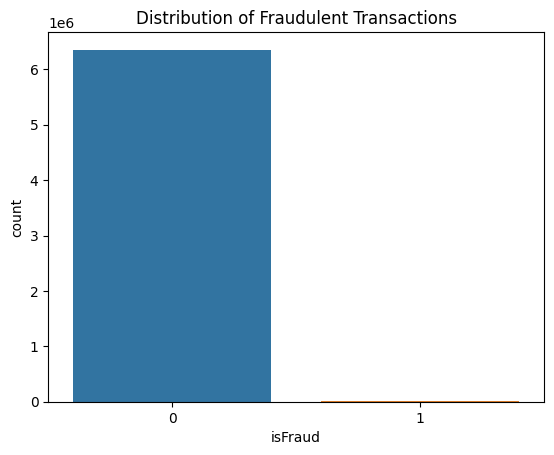

In [11]:
# Distribution of the target variable 'isFraud'
sns.countplot(data=df, x='isFraud')
plt.title('Distribution of Fraudulent Transactions')
plt.show()

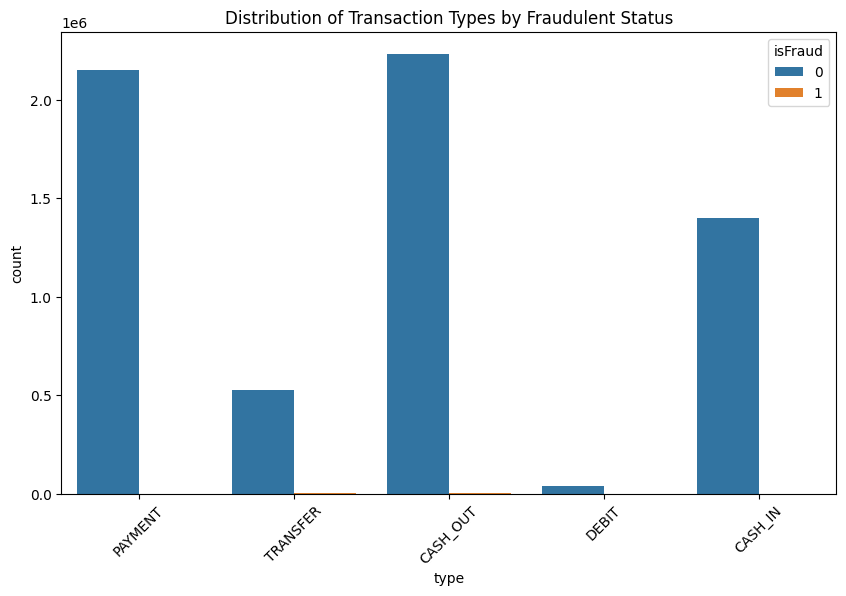

In [12]:
# Distribution of transaction types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', hue='isFraud')
plt.title('Distribution of Transaction Types by Fraudulent Status')
plt.xticks(rotation=45)
plt.show()

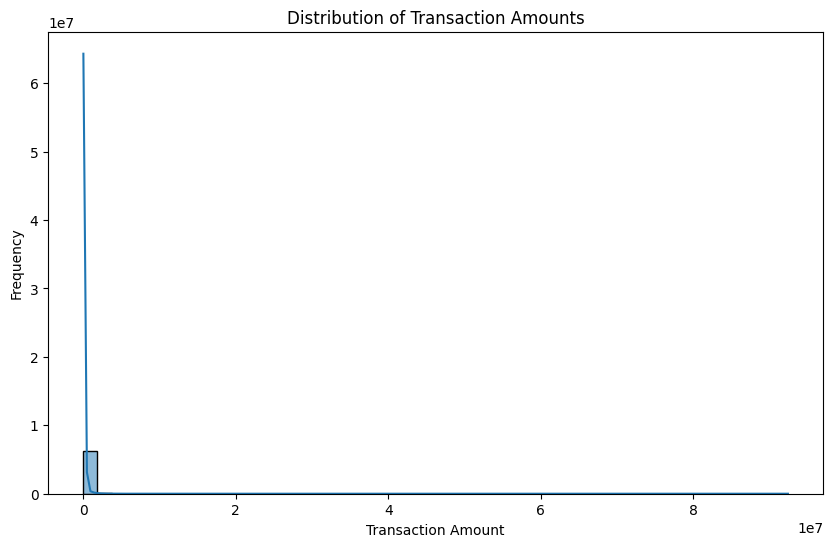

In [13]:
# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

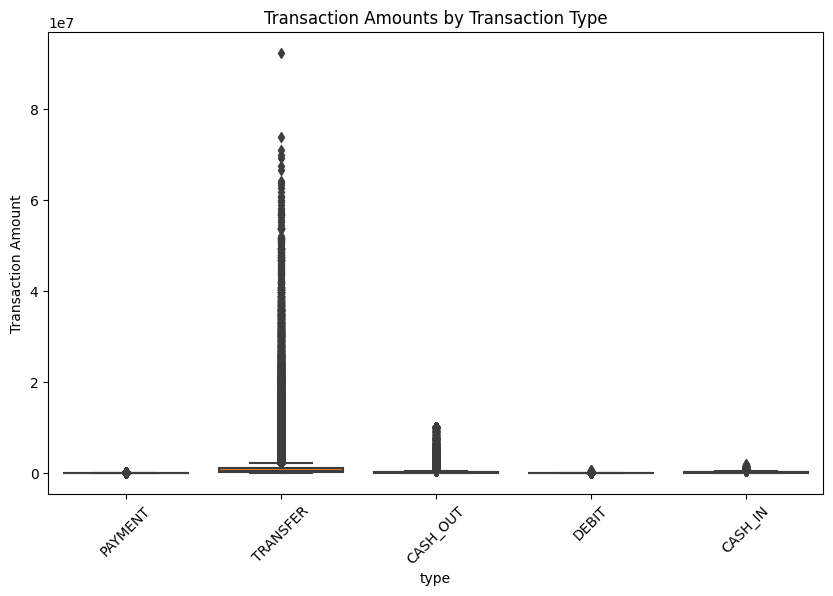

In [14]:
# Box plot of transaction amounts by transaction type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='type', y='amount')
plt.title('Transaction Amounts by Transaction Type')
plt.xticks(rotation=45)
plt.ylabel('Transaction Amount')
plt.show()

In [17]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


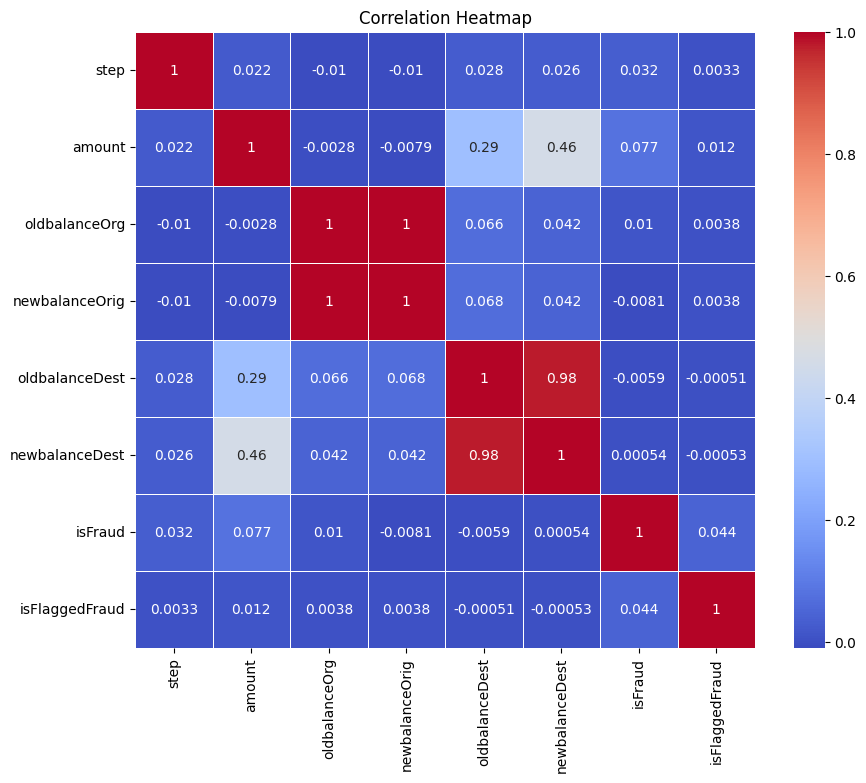

In [16]:
numeric_columns = df.select_dtypes(include=[np.number])

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = numeric_columns.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### As the 'oldbalanceOrg' and 'newbalanceOrig' and 'oldbalanceDest' and 'newbalanceDest' have high correlation with each other it can lead to multicollinearity. So, it is best practice to remove one of the attributes or features. but, in this case as the four features have very low correlation with the target variable, I shall remove all of them to reduce the complexity and I shall also remove the categorical column as they are simply not useful 

In [18]:
columns_to_drop = ['nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']
df = df.drop(columns=columns_to_drop)

In [19]:
df.head()

,step,type,amount,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,0,0
1,1,PAYMENT,1864.28,0,0
2,1,TRANSFER,181.00,1,0
3,1,CASH_OUT,181.00,1,0
4,1,PAYMENT,11668.14,0,0


In [21]:
cat_columns = ['type']
label_encoders = {}
for column in cat_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [22]:
df.head()

,step,type,amount,isFraud,isFlaggedFraud
0,1,3,9839.64,0,0
1,1,3,1864.28,0,0
2,1,4,181.00,1,0
3,1,1,181.00,1,0
4,1,3,11668.14,0,0


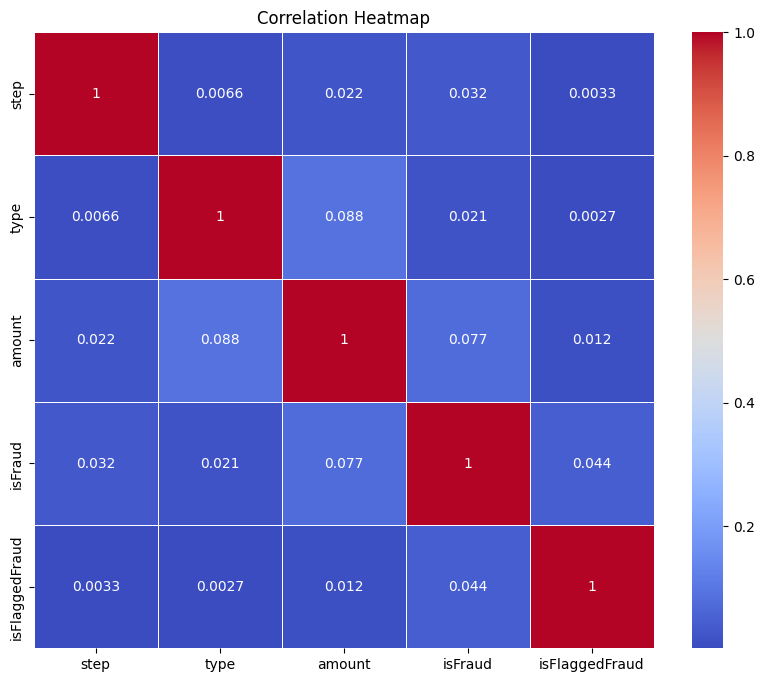

In [23]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [24]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [28]:
columns = ['amount'] 
# Standardize numerical features
scaler = StandardScaler()
X[columns] = scaler.fit_transform(X[columns])

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Model selection and training
lgb_classifier = lgb.LGBMClassifier(random_state=42)

In [31]:
# Hyperparameter tuning using GridSearchCV (fine-tuning)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63]
}

In [33]:
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 5778, number of negative: 4448056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001297 -> initscore=-6.646165
[LightGBM] [Info] Start training from score -6.646165


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [5, 10, 20],
                         'n_estimators': [100, 200], 'num_leaves': [31, 63]},
             scoring='roc_auc', verbose=2)

In [34]:
# Get the best hyperparameters
best_params = grid_search.best_params_

In [35]:
final_lgb_classifier = lgb.LGBMClassifier(random_state=42, **best_params)
final_lgb_classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5778, number of negative: 4448056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001297 -> initscore=-6.646165
[LightGBM] [Info] Start training from score -6.646165


LGBMClassifier(learning_rate=0.05, max_depth=20, n_estimators=200,
               num_leaves=63, random_state=42)

In [36]:
# Model evaluation
y_pred = final_lgb_classifier.predict(X_test)
y_pred_proba = final_lgb_classifier.predict_proba(X_test)[:, 1]

In [37]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

In [38]:
# Visualize feature importance
feature_importance = final_lgb_classifier.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

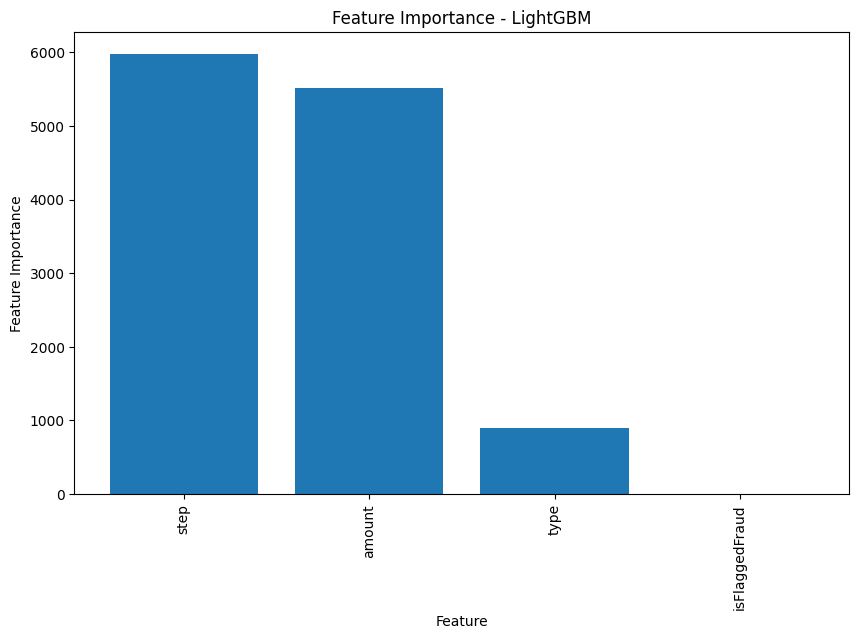

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importance[sorted_idx], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance - LightGBM')
plt.show()

In [40]:
print(accuracy)

0.9989134455093447


In [41]:
print(precision)

0.7612156295224313


In [42]:
print(recall)

0.2160164271047228


In [43]:
print(f1)

0.3365323096609085


In [44]:
print(roc_auc)

0.9513981505010093


In [45]:
print(conf_matrix)

[[1906186     165]
 [   1909     526]]
